In [11]:
import pandas as pd
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy import stats

In [12]:
#read metadata csv
nifty_meta = pd.read_csv(r'pairs_nifty_meta.csv')

# get the ticker list with industry is equal to FINANCIAL SERVICES
tickers = list(nifty_meta[nifty_meta.Industry == 'FINANCIAL SERVICES'].Symbol)

# start and end dates for backtesting
fromdate = datetime.datetime(2010, 1, 1)
todate = datetime.datetime(2014, 6, 15)

# read back the pricing data
prices = pd.read_csv(r'pairs_prices.csv', index_col=['ticker','date'], parse_dates=True)

idx = pd.IndexSlice
# remove tickers where we have less than 10 years of data.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
prices = prices.loc[idx[keep,:], :]

# final tickers list
TICKERS = list(prices.index.get_level_values('ticker').unique())

# unstack and take close price
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()

In [13]:
# Find the stocks return matrix
R = close.diff()

# Delete the first row of NaN values
R = R.iloc[1:, :]

# Standardize the returns
Y = (R - R.mean()) / R.std()

# Get covariance and correlation matrix of standardized returns
Covariance = Y.cov()
Correlation = Y.corr()

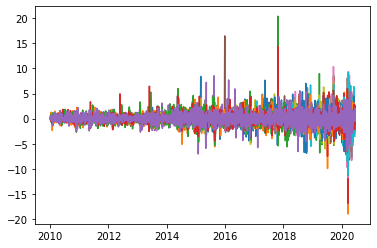

In [14]:
# Plot the returns matrix to see they're roughly on the same scale
plt.plot(Y)
plt.show()

In [15]:
# Confirm that we have stationary time series
adf = -100
for i in range(1, 11):
    x = adfuller(Y.iloc[:, 10].dropna())
    adf = max(x[0], adf)
print("Max ADF critical value - ", adf)

Max ADF critical value -  -10.290149572716915


In [16]:
# Find the eigenvalues and eigenvectors
eig_vals,eig_vecs = np.linalg.eig(Covariance)

# Sort eigenvalues and eigenvectors in decreasing order
idx = eig_vals.argsort()[::-1]   
eigenvalues = eig_vals[idx]
eig_vecs = eig_vecs[:,idx]

print(eigenvalues)

[6.20297605 1.99975208 0.96841302 0.8279573  0.72135452 0.65851141
 0.61263924 0.5988426  0.56273827 0.47495585 0.34262819 0.29719577
 0.28114667 0.26283856 0.18805047]


In [19]:
def solve(k1, k2):

    xl = []
    yl = []



    #set up the labels so that central points are blank
    tickers = list(Y.columns)

    #insert some spacers as we want pairs of labels
    for index, item in enumerate(tickers):
        if index % 2 == 0:
            tickers.insert(index,'')


    #build up data points for loadings plot
    for i in range(eig_vecs.shape[0]):

        x_val = [0,eig_vecs[i,k1]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))]
        y_val = [0,eig_vecs[i,k2]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))]
        xl.append(x_val)
        yl.append(y_val)

    #convert list of lists to list     
    flattenedx = [val for sublist in xl for val in sublist]
    flattenedy = [val for sublist in yl for val in sublist]

    # print(flattenedx)
    # print(flattenedy)

    #list to contain tuples (ith example, quandrant location 1,2,3,4)
    quad = []

    for i in range(eig_vecs.shape[0]):
        x = eig_vecs[i,k1]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))
        y = eig_vecs[i,k2]*(0 if eig_vals[i]<0 else np.sqrt(eig_vals[i]))
        
        #calculate the location of each indicies wrt the quadrant of the loading plot
        if((x > 0) and (y > 0)):
            quad.append((i, 1))
        elif((x < 0) and (y > 0)):
            quad.append((i, 2))
        elif((x < 0) and (y < 0)):
            quad.append((i, 3))
        elif((x > 0) and (y < 0)):
            quad.append((i, 4))


    #reset the tickers to the original format
    tickers = list(Y.columns)

    #collect the entities for ranking later
    corrells = pd.DataFrame(columns=["Stock/index_A","Stock/index_B","R^2"])

    #select the stocks only
    stocks = tickers[:10]

    #calculate quadrant membership and determine opposing pairs
    for i in range(len(quad)):
        # Q1 vs Q3
        if(quad[i][1] == 1):
            for j in range(len(quad)):
                #we are only interested in correlations that involve at least 1 stock
                if(quad[j][1] == 3 and ((tickers[quad[i][0]] in stocks) or (tickers[quad[j][0]] in stocks)) ):

                    ts1 = Y[tickers[quad[i][0]]]  # time-series for cross plots
                    ts2 = Y[tickers[quad[j][0]]]
    
                    # correlation metrics 
                    slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
            
                    corrells = corrells.append({"Stock/index_A":tickers[quad[i][0]],"Stock/index_B":tickers[quad[j][0]],"R^2":r2},ignore_index=True)
                    
                        
                        
        # Q2 vs Q4
        if(quad[i][1] == 2):
            for j in range(len(quad)):
                if(quad[j][1] == 4 and ((tickers[quad[i][0]] in stocks) or (tickers[quad[j][0]] in stocks))):
                
                    ts1 = Y[tickers[quad[i][0]]]  # time-series for cross plots
                    ts2 = Y[tickers[quad[j][0]]]
    
                    # correlation metrics 
                    slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)

                    corrells = corrells.append({"Stock/index_A":tickers[quad[i][0]],"Stock/index_B":tickers[quad[j][0]],"R^2":r2},ignore_index=True)

    corrells = corrells.sort_values(by="R^2",ascending=False)
    corrells = corrells.reset_index(drop=True)
    return corrells.head(3)

In [20]:
for i in range(13, 0, -1):
    print(f"Components chosen - {15 - i - 1} and {15 - i}")
    print(solve(-i, -i - 1))

Components chosen - 1 and 2
  Stock/index_A Stock/index_B       R^2
0    BAJFINANCE     ICICIBANK  0.484756
1    BAJAJFINSV     ICICIBANK  0.476160
2    BAJAJFINSV      AXISBANK  0.453894
Components chosen - 2 and 3
  Stock/index_A Stock/index_B       R^2
0      HDFCBANK    BAJFINANCE  0.547194
1     KOTAKBANK    BAJFINANCE  0.524792
2      HDFCBANK    BAJAJFINSV  0.522969
Components chosen - 3 and 4
  Stock/index_A Stock/index_B       R^2
0      HDFCBANK     ICICIBANK  0.536859
1      AXISBANK          SBIN  0.532475
2          HDFC     ICICIBANK  0.497268
Components chosen - 4 and 5
  Stock/index_A Stock/index_B       R^2
0          SBIN     ICICIBANK  0.617723
1          SBIN      AXISBANK  0.532475
2     KOTAKBANK     ICICIBANK  0.462388
Components chosen - 5 and 6
  Stock/index_A Stock/index_B       R^2
0    BAJFINANCE     KOTAKBANK  0.524792
1    BAJAJFINSV     KOTAKBANK  0.493884
2     ICICIBANK     KOTAKBANK  0.462388
Components chosen - 6 and 7
  Stock/index_A Stock/index_B   

In [9]:
# Questions:
# Does it need to be a quadrant? --> Easier to code because x > 0 and y > 0 
# Add an explanation of eigenvalues and eigenvectors --> How are they being used in the strategy?
# Choose -3 and -4 components only? Options : train/validation set, or iterate over all combinations 
# ALso see what happens on taking best fit (strongest components) and compare
# See if number of components can be increased